## Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Data files for Colab/train.csv'
train = pd.read_csv(path)
train.drop('ID',inplace=True,axis=1)

In [4]:
train.head(2)

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,"Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagnostic\nmanner, i.e. without information on condition presence. Reconstruction is posed\nas a Maximum-A-Posteriori problem with a prior model whose parameters are\nestimated from training data in a classifier-specific fashion. Experimental\nevaluation is performed on synthetically generated data and data from the\nAlzheimer's Disease Neuroimaging Initiative (ADNI) database. Results on\nsynthetic data demonstrate that using RSM yields higher detection accuracy\ncompared to using models directly or with bootstrap averaging. Analyses on the\nADNI dataset show that RSM can also improve correlation between\nsubject-specific detections in cortical thickness data and non-imaging markers\nof Alzheimer's Disease (AD), such as the Mini Mental State Examination Score\nand Cerebrospinal Fluid amyloid-$\beta$ levels. Further reliability studies on\nthe longitudinal ADNI dataset show improvement on detection reliability when\nRSM is used.\n",1,0,0,0,0,0
1,Rotation Invariance Neural Network,"Rotation invariance and translation invariance have great values in image\nrecognition tasks. In this paper, we bring a new architecture in convolutional\nneural network (CNN) named cyclic convolutional layer to achieve rotation\ninvariance in 2-D symbol recognition. We can also get the position and\norientation of the 2-D symbol by the network to achieve detection purpose for\nmultiple non-overlap target. Last but not least, this architecture can achieve\none-shot learning in some cases using those invariance.\n",1,0,0,0,0,0


Let us separate the feature and target matrix first. For features, we will only use the abstract based on the assumption that the title's words are largely paraphrased again in the abstract

In [5]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [6]:
train['length'] = train['ABSTRACT'].apply(len)
train['total'] = train[labels].sum(axis=1)

In [7]:
X = train[['ABSTRACT','length']]
y = train [['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

## EDA

Majority of articles i.e. 40% belong to computer science followed by physics, mathematics and statistics between 20 to 30% of articles. Quantitative Biology and Quantiative Finance have fewer articles considering it is a niche field of study   

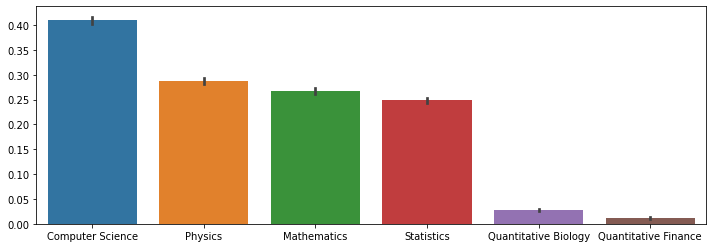

In [8]:
plt.figure(figsize=(12,4))
sns.barplot(data=y);

Majority of the articles i.e. 16k out of 20k entries belong to only one category whereas fewer have 2 and 3 categories attributed to it

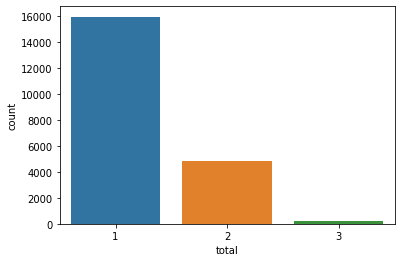

In [9]:
sns.countplot(train['total']);

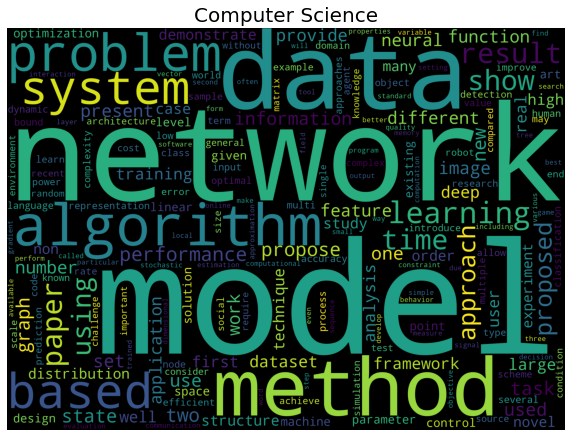

In [10]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,10))
subset = train[train['Computer Science']==True]
text = subset['ABSTRACT'].values
cloud_cs = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Computer Science",fontsize=20)
plt.imshow(cloud_cs);

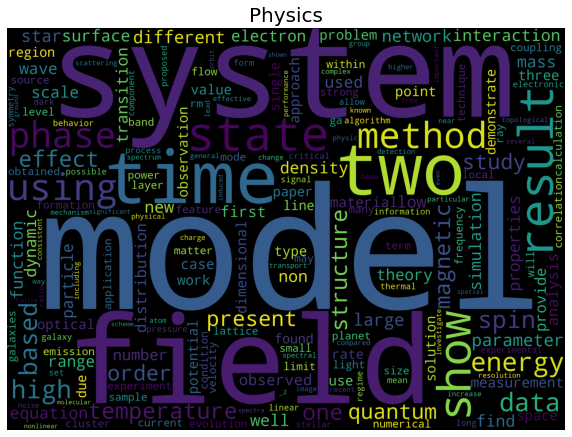

In [11]:
plt.figure(figsize=(10,10))
subset = train[train['Physics']==True]
text = subset['ABSTRACT'].values
cloud_phy = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Physics",fontsize=20)
plt.imshow(cloud_phy);

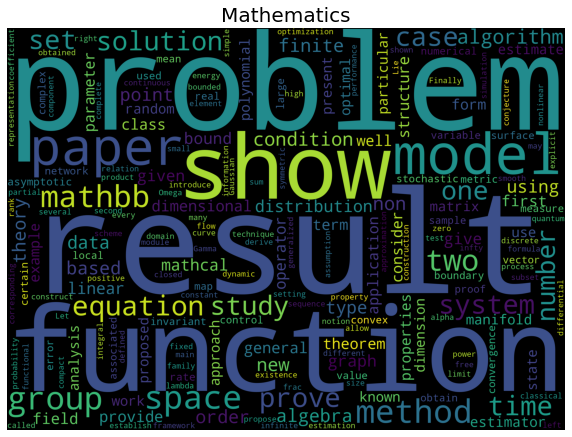

In [12]:
plt.figure(figsize=(10,10))
subset = train[train['Mathematics']==True]
text = subset['ABSTRACT'].values
cloud_math = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Mathematics",fontsize=20)
plt.imshow(cloud_math);

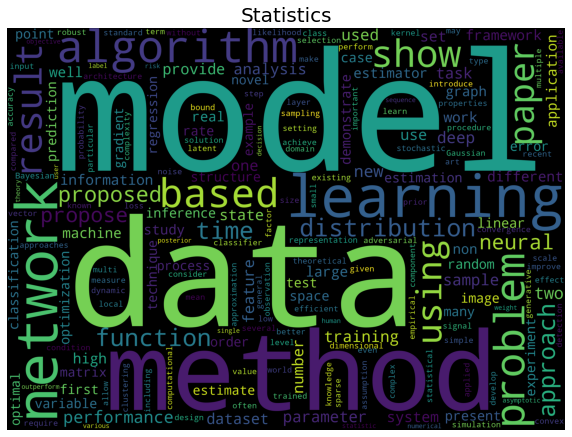

In [13]:
plt.figure(figsize=(10,10))
subset = train[train['Statistics']==True]
text = subset['ABSTRACT'].values
cloud_stat = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Statistics",fontsize=20)
plt.imshow(cloud_stat);

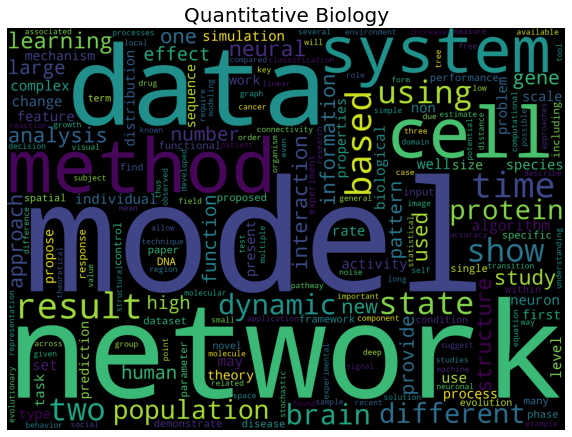

In [14]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Biology']==True]
text = subset['ABSTRACT'].values
cloud_qtbio = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Biology",fontsize=20)
plt.imshow(cloud_qtbio);

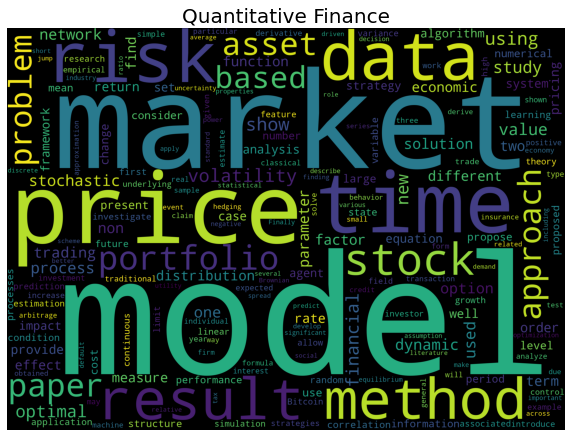

In [15]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Finance']==True]
text = subset['ABSTRACT'].values
cloud_qtfin = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Finance",fontsize=20)
plt.imshow(cloud_qtfin);

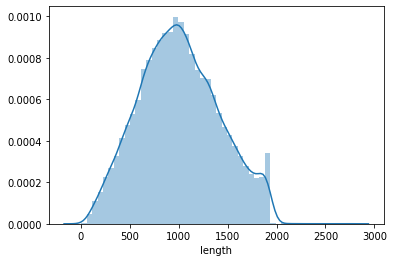

In [16]:
sns.distplot(train['length']);

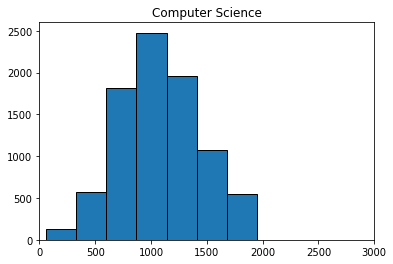

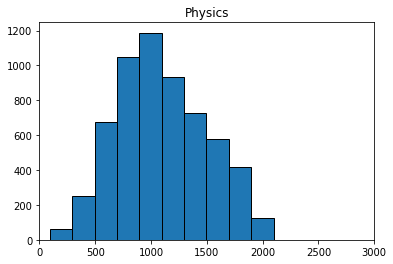

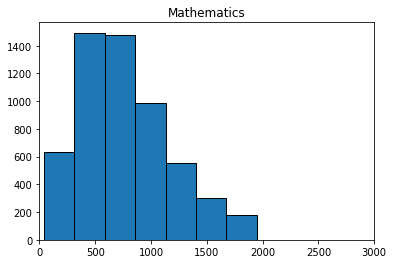

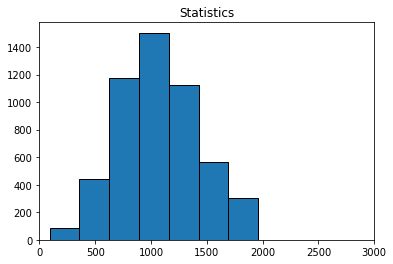

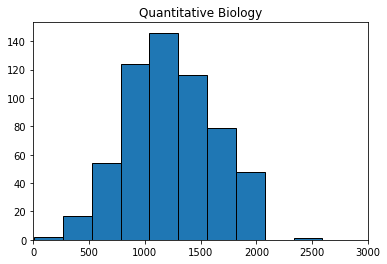

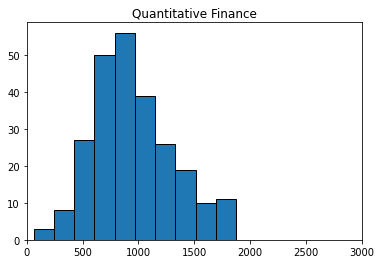

In [17]:
for i in y.columns.to_list():
    plt.hist(train[train[i]==1]['length'],label=i,edgecolor='black')
    plt.xlim(0,3000)
    plt.title(i)
    plt.show()

## Pre-processing the text data

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [19]:
corpus = []
for i in range(0, len(X)):
    #Removing punctuations
    abstract = re.sub('[^a-zA-Z]', ' ', X['ABSTRACT'][i]) #replacing punctuations with blank space
    
    #Converting all to lower case letters 
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()

    #Stemming and removing stopwords
    #ps = PorterStemmer() 
    #abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

    #Lemmatization and removing stopwords
    wordnet_lemmatizer = WordNetLemmatizer()
    abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

    #Joining the words back to form a paragraph 
    abstract = ' '.join(abstract)
    corpus.append(abstract)

In [20]:
corpus[0] #lemmitized output

'predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global e identifiying condition presence subject local e detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner e without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fashion experimental evaluation performed synt

In [ ]:
corpus[0] #stemmed output

'predict model allow subject specif infer analyz diseas relat alter neuroimag data given subject data infer made two level global e identifiy condit presenc subject local e detect condit effect individu measur extract subject data global infer wide use local infer use form subject specif effect map rare use exist model often yield noisi detect compos dispers isol island articl propos reconstruct method name rsm improv subject specif detect predict model approach particular binari classifi rsm specif aim reduc nois due sampl error associ use finit sampl exampl train classifi propos method wrapper type algorithm use differ binari classifi diagnost manner e without inform condit presenc reconstruct pose maximum posteriori problem prior model whose paramet estim train data classifi specif fashion experiment evalu perform synthet gener data data alzheim diseas neuroimag initi adni databas result synthet data demonstr use rsm yield higher detect accuraci compar use model directli bootstrap a

## Vectorization - Creating bag of words model

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# pipe = Pipeline([('count', CountVectorizer(max_features = 5000,ngram_range=(1,3))),('tfid', TfidfTransformer())])
# X = pipe.fit_transform(corpus).toarray()

cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [50]:
X.shape

(20972, 5000)

## Adding features to BOW array

In [51]:
length = train['length'].values
length.shape

(20972,)

In [52]:
#Converting 1D to 2D array
new_len = np.reshape(length, (-1, 1))
new_len.shape

(20972, 1)

In [53]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_len = sc.fit_transform(new_len)

In [54]:
X = np.append(X,new_len,axis=1)

In [55]:
X.shape

(20972, 5001)

In [56]:
y = train[labels].values

## Splitting the data 

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
# count_df = pd.DataFrame(X_train, columns=cv.get_feature_names())

## Building the model

In [30]:
print(X_train.shape)
print(y_train.shape)
print(type(y_train))

(16777, 5001)
(16777, 6)
<class 'numpy.ndarray'>


In [31]:
from sklearn.metrics import f1_score, accuracy_score
# using classifier chains
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
rfc = MultiOutputClassifier(RandomForestClassifier())

# train
rfc.fit(X_train, y_train)

# predict
rfc_predictions = rfc.predict(X_test)

print('RFC',f1_score(y_test,rfc_predictions,average='micro'))

RFC 0.7959163044576973


In [32]:
# LGBM classifier
from lightgbm import LGBMClassifier

lgb = MultiOutputClassifier(LGBMClassifier())
lgb.fit(X_train,y_train)
lgb_predictions = lgb.predict(X_test)
print('LGB',f1_score(y_test,lgb_predictions,average='micro'))

LGB 0.8070175438596492


In [82]:
#Deep learning model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout


dl_model = Sequential()

# Reference - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

dl_model.add(Dense(5001,activation='relu'))
dl_model.add(Dropout(0.5))

dl_model.add(Dense(2504,activation='relu'))
dl_model.add(Dropout(0.5))

# dl_model.add(Dense(50,activation='relu'))
# dl_model.add(Dropout(0.5))

dl_model.add(Dense(6,activation='sigmoid'))

# Remember to compile()

dl_model.compile(optimizer='adam',loss='binary_crossentropy')

In [83]:
dl_model.fit(x=X_train,y=y_train,validation_data=(X_test, y_test),epochs=1)

525/525 [==============================] - 92s 175ms/step - loss: 0.2223 - val_loss: 0.1833


In [84]:
losses = pd.DataFrame(dl_model.history.history)
losses

,loss,val_loss
0,0.22231,0.183254


In [97]:
dl_predictions = dl_model.predict(X_test)

In [98]:
dl_predictions

array([[8.2542092e-02, 1.6765893e-03, 8.7287855e-01, 9.8800588e-01,
        6.1982901e-05, 1.6355515e-04],
       [9.9986082e-01, 1.3813376e-04, 1.6811490e-04, 1.0208528e-04,
        4.9686051e-09, 2.2567463e-09],
       [2.1310329e-02, 5.7812464e-01, 8.7828946e-01, 5.8458149e-03,
        7.6006145e-05, 2.6860860e-05],
       ...,
       [7.4714267e-01, 1.1713207e-03, 2.4061650e-02, 9.4199145e-01,
        9.2658401e-04, 1.1942055e-05],
       [5.4944485e-02, 9.6228719e-04, 9.6324182e-01, 6.3796043e-03,
        9.4089677e-07, 1.6499511e-06],
       [9.9633420e-01, 3.2270895e-05, 1.2244732e-04, 5.8764249e-02,
        8.8694662e-07, 8.8774414e-08]], dtype=float32)

In [ ]:
dl_predictions[dl_predictions>=0.48] = int(1)
dl_predictions[dl_predictions<0.48] = int(0)


In [103]:
for i in range(30,50):
  i=i/100
  dl_predictions = dl_model.predict(X_test)
  dl_predictions[dl_predictions>=i] = int(1)
  dl_predictions[dl_predictions<i] = int(0)
  print(i,f1_score(y_test,dl_predictions,average='micro'))

0.3 0.8149960674648256
0.31 0.8171986283302559
0.32 0.8180693069306931
0.33 0.8186500888099466
0.34 0.8197892480800142
0.35 0.8203195117573147
0.36 0.8214575995665132
0.37 0.8229195088676671
0.38 0.8238090884154704
0.39 0.8246114227903981
0.4 0.8258172052967867
0.41 0.8267386649287775
0.42 0.8261643707243933
0.43 0.8268777683535953
0.44 0.8267955277619858
0.45 0.8262070279021047
0.46 0.825184192900201
0.47 0.8246728252501925
0.48 0.8243713733075435
0.49 0.8236665695132614


In [104]:
dl_predictions = dl_model.predict(X_test)
dl_predictions[dl_predictions>=0.43] = int(1)
dl_predictions[dl_predictions<0.43] = int(0)

In [105]:
dl_predictions

array([[0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [106]:
print('DL model',f1_score(y_test,dl_predictions,average='micro'))

DL model 0.8268777683535953


In [107]:
from sklearn.metrics import classification_report
print(classification_report(y_test,dl_predictions))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1736
           1       0.87      0.91      0.89      1165
           2       0.80      0.82      0.81      1133
           3       0.78      0.77      0.77      1053
           4       0.88      0.12      0.22       112
           5       0.68      0.32      0.43        47

   micro avg       0.82      0.84      0.83      5246
   macro avg       0.80      0.64      0.66      5246
weighted avg       0.82      0.84      0.82      5246
 samples avg       0.85      0.86      0.84      5246



Let us use only one epoch for training the model on the entire available X and y dataset, to avoid overfitting

## Final model trained on entire dataset

In [ ]:
# model = MultiOutputClassifier(LGBMClassifier())
# model.fit(X,y)

## Predicting test results

In [108]:
test_df = pd.read_csv('/content/drive/My Drive/Data files for Colab/test.csv')

In [109]:
test_df.shape

(8989, 3)

In [110]:
test_df.drop(['ID','TITLE'],inplace=True,axis=1)
test_df['length'] = train['ABSTRACT'].apply(len)
test_length = test_df['length'].values
test_length = np.reshape(test_length, (-1, 1))
test_length = sc.transform(test_length)

In [111]:
test_corpus = []
for i in range(0, len(test_df)):
    #Removing punctuations
    abstract = re.sub('[^a-zA-Z]', ' ', test_df['ABSTRACT'][i]) #replacing punctuations with blank space
    
    #Converting all to lower case letters 
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()

    #Stemming and removing stopwords
    #ps = PorterStemmer() 
    #abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

    #Lemmatization and removing stopwords
    wordnet_lemmatizer = WordNetLemmatizer()
    abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

    #Joining the words back to form a paragraph 
    abstract = ' '.join(abstract)
    test_corpus.append(abstract)

In [112]:
test = cv.transform(test_corpus).toarray()
test = np.append(test,test_length,axis=1)
test.shape

(8989, 5001)

In [113]:
submission = dl_model.predict(test)
submission

array([[4.0210468e-01, 4.1831315e-02, 3.3362681e-01, 8.1033838e-01,
        4.1687191e-03, 1.1409521e-02],
       [8.3917379e-04, 9.9707830e-01, 1.6717911e-03, 3.1907260e-03,
        5.8064128e-05, 1.6244661e-07],
       [9.1509676e-01, 1.6736656e-02, 5.1444918e-02, 4.6634883e-02,
        8.6164474e-04, 3.0592084e-04],
       ...,
       [3.0441087e-01, 8.1769466e-02, 2.5295705e-02, 2.0814174e-01,
        4.7262156e-01, 1.4678240e-03],
       [2.8556627e-01, 2.4484992e-03, 2.9049250e-01, 9.2222315e-01,
        5.8057904e-04, 3.2278001e-03],
       [5.8974266e-01, 6.8041474e-02, 3.9162320e-01, 7.6622725e-02,
        6.2832832e-03, 5.3043067e-03]], dtype=float32)

In [114]:
submission[submission>=0.43] = int(1)
submission[submission<0.43] = int(0)
submission

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [115]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
sub = pd.DataFrame(data=submission,columns=labels)
test_ids = np.arange(20973,29962)
sub['ID'] = test_ids
sub.shape

(8989, 7)

In [116]:
sub = sub[['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]

In [117]:
sub[labels] = sub[labels].astype('int')

In [118]:
sub.tail()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8984,29957,1,0,0,0,0,0
8985,29958,0,0,1,0,0,0
8986,29959,0,0,0,0,1,0
8987,29960,0,0,0,1,0,0
8988,29961,1,0,0,0,0,0


In [119]:
sub.to_csv('submission_v6.csv',index=False)